In [1]:
import pandas as pd
import numpy as np
from bayes_approach import Bayesian_AB
import numpy as np
import arviz as az
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [3]:
query = '''
with precondition as (
    SELECT
    	DISTINCT(t.session_id) as session_id
    FROM
    	HEYCAR.TRACKING t
        
    JOIN
        HEYCAR.SESSION s on t.session_id = s.session_id
    WHERE
    	t.event_name = 'pages'
        AND t.page_type = 'PDP'
        AND t.event_day  >= '2021-08-01'
        AND t.platform_id = 0
        AND s.device_type in ('mobile')
        AND (s.is_bot is null OR s.is_bot = 0)
        AND s.has_tracking_consent = 1
        AND s.country_code = 'de'
        AND t.country_code = 'de'
), sessions as (
	SELECT
		t.session_id,
		s.session_day,
		t.ab_test_group_name as test_group
    FROM
    	HEYCAR.TRACKING t
    JOIN
        HEYCAR.SESSION s on t.session_id = s.session_id
    WHERE
    	t.event_day  >= '2021-08-09'
        AND s.session_day  >= '2021-08-10'
        AND t.ab_test_id = '209'
        AND t.platform_id = 0
        AND s.device_type in ('mobile')
        AND (s.is_bot is null OR s.is_bot = 0)
        AND s.has_tracking_consent = 1
        AND t.country_code = 'de'
        AND s.country_code = 'de'
        AND t.session_id in (SELECT session_id FROM precondition)
    GROUP BY
    	1, 2, 3
), leads as (

	SELECT
		sl.session_id,
		sl.session_day,
		1 as leads
	FROM
		HEYCAR.SESSION_LEAD_LOOKUP sl
    JOIN
        HEYCAR.LEAD l on sl.lead_id = l.lead_id
	WHERE
        sl.session_day >= '2021-08-10'
        AND sl.country_code = 'de' 
        AND l.IS_QUALITY_LEAD = 1
    GROUP BY
        1, 2
)
SELECT
    s.session_id,
	s.session_day,
	s.test_group,
	nvl(l.leads, 0) as leads
FROM
	sessions s
LEFT JOIN
	leads l on s.session_id = l.session_id
'''

In [4]:
E = Bayesian_AB(project_name='CLASS-530_vertical_recommendation_PDP-mobile')

In [5]:
df = E.get_data(load_new=True, query=query)
df

,session_id,session_day,test_group,leads
0,ajs-43716a85049bec15a42c3e7dea9789f6,2021-08-14,show_carousel_control,1
1,ajs-b7cdba1ebdb2fd5729285cdf7e714104,2021-08-14,show_carousel_control,1
2,ajs-6f3adb3f05ac71d616a806fb63929f28,2021-08-14,show_vertically_variant,1
3,ajs-ba04c0c16b58524f77f88cba07fd303f,2021-08-16,show_carousel_control,1
4,ajs-7305921db6d3ceb28c5c109666d9afd5,2021-08-16,show_vertically_variant,1
...,...,...,...,...
353527,ajs-24360dad9b7b6c9a98ead658faca8245,2021-08-15,show_carousel_control,0
353528,ajs-3fac9fde11e89200529357d96b67d465,2021-08-13,show_carousel_control,0
353529,ajs-a345d8b52848a581033666789266baca,2021-08-14,show_vertically_variant,0
353530,ajs-dce361f6fc43b401133ebc347b3d8576,2021-08-10,show_vertically_variant,0


In [6]:
c, v = E.prepare_data(df,
                      control_filter='show_carousel_control',
                      variant_filter='show_vertically_variant',
                      date_column='session_day',
                      sample_column='session_id',
                      conversion_column='leads',
                      test_column='test_group',
                      day_index=True
                     ) 
#control group & variant group

In [7]:
c

,session_id,leads
DAY,,
0,22179,133
1,22200,146
2,21443,110
3,21074,109
4,21213,95
5,24508,63
6,23096,128
7,21926,86


In [8]:
v

,session_id,leads
DAY,,
0,22050,119
1,21231,123
2,21386,117
3,21001,103
4,20856,80
5,24195,74
6,23446,116
7,21728,109


In [9]:
simulation_ImSa = E.posterior_analytic_importance_sampling(control=c,
                                                           variant=v)

In [10]:
simulation_ImSa

,simulations,day,variant_expected_loss,control_expected_loss,prob_variant_better_than_control,prob_variant_better_control_error,control_cvr,control_cvr_lower,control_cvr_upper,variant_cvr,variant_cvr_lower,variant_cvr_upper
0,1,0,0.000681,0.000081,0.201067,0.000546,0.006041206437942383,0.005064,0.007102,0.005441683294032287,0.004514,0.006454
1,1,1,0.000717,0.000022,0.090799,0.000347,0.006309006106216624,0.005594,0.007066,0.005614213432525472,0.004932,0.006339
2,1,2,0.000403,0.000046,0.195623,0.000537,0.005924890617403987,0.005353,0.006525,0.005566809445020025,0.005008,0.006155
3,1,3,0.000372,0.000033,0.171720,0.000501,0.005742364611383461,0.005251,0.006255,0.005404458970468075,0.004925,0.005906
4,1,4,0.000412,0.000015,0.102092,0.000372,0.005494353026056553,0.005062,0.005944,0.005097347126523102,0.004679,0.005534
5,1,5,0.000263,0.000029,0.192934,0.000533,0.0049540412761369034,0.004583,0.005339,0.004719976132373529,0.004356,0.005099
6,1,6,0.000303,0.000016,0.126571,0.000422,0.005041261278617988,0.004696,0.005399,0.004754584314412293,0.004417,0.005104
7,1,7,0.000162,0.000046,0.309809,0.000675,0.00490314735899933,0.004584,0.005233,0.0047869467580090395,0.004470,0.005115


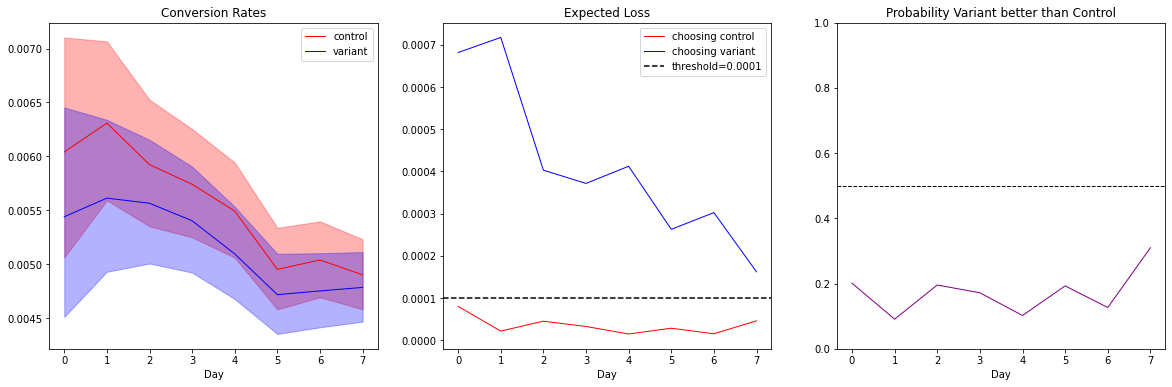

In [11]:
E.plot_expected_loss(simulation_ImSa)

In [12]:
E.get_results()

VALUE
GROUP   METRIC                                       
control CvR                                   0.00490
        sample size                            177639
        conversions                               870
        95% credible interval      (0.00458, 0.00523)
variant CvR                                   0.00479
        sample size                            175893
        conversions                               841
        95% credible interval      (0.00447, 0.00511)
outcome uplift                                -2.370%
        control expected loss             4.63906e-05
        variant expected loss              0.00016234
        prob (variant >= control)             30.981%
        standard error                     0.00067475